# CellPose 2 cell segmentation


## Infrastructure

- [x] VSC Tier 1

## EasyBuild Modules

```bash
JupyterNotebook/6.4.0-GCCcore-11.3.0-IPython-8.5.0

matplotlib/3.5.2-foss-2022a
Cellpose/2.2.2-foss-2022a
AICSImageIO/4.14.0-foss-2022a
```

## Jupyter notebook

Run with Jupyter notebook with kernel `Python 3 (ipykernel)`

## Goal

Run CellPose 2 model on a 2D image using only easybuild modules



### Import libraries

In [3]:
import os
import glob

from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

from skimage import io, morphology, filters,exposure, measure, segmentation
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import try_all_threshold, threshold_li, threshold_isodata
from skimage.measure import regionprops_table
from skimage.io import imshow

from cellpose import models
from cellpose import plot
import cellpose

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

01-Sep-25 16:29:08 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


### Image Path

In [4]:
img_path = '/dodrio/scratch/projects/2024_300/training/2025/data/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x_s02_MIP.ome.tiff'

### Open the Image with [aicsimageio](https://allencellmodeling.github.io/aicsimageio/)

In [15]:
img = AICSImage(img_path)
print("img dims order: {}".format(img.dims.order))
print("img shape: {}".format(img.shape))

img dims order: TCZYX
img shape: (1, 3, 1, 512, 512)


### Extract only the usefull channel for segmentation

In [16]:
nuclei_cell_image = img.get_image_data("TCZYX")[:,[1, 2],:, :,:]
print("nuclei_cell_image shape: {}".format(nuclei_cell_image.shape))

nuclei_cell_image shape: (1, 2, 1, 512, 512)


### Load the CellPose model `cyto2`

In [9]:
model = models.Cellpose(gpu=True, model_type='cyto2')

### Run CellPose

In [23]:
cellpose_cell_diameter = 100 # in Pixel
min_cell_vol = 15 # in Pixel

#Segment
labels, flows, _, _ = model.eval(nuclei_cell_image, diameter=cellpose_cell_diameter, channels=[1,2], do_3D=False)

### Filter the labels

In [27]:
# Filter by area
label_filtered = morphology.remove_small_objects(labels, min_size=int(min_cell_vol))

# Clear cell touching the border
segmentation.clear_border(label_filtered, out=label_filtered)

# Relabel
label_filtered, _, _ = segmentation.relabel_sequential(label_filtered, offset=1)

### Plot the Result

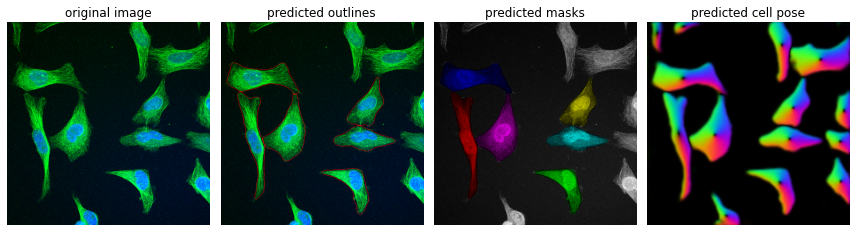

In [34]:
channels = [2,3]
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, nuclei_cell_image.squeeze(), label_filtered, flows[0], channels=channels)
plt.tight_layout()
plt.show()